## IMPORTS

In [ ]:
from skimage import filters
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib
from skimage import data, img_as_float
from skimage import exposure
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Conv2D, Dropout, GlobalMaxPooling2D,MaxPool2D, \
Flatten, Dense, Activation, BatchNormalization, MaxPooling2D,LeakyReLU
import random
from tensorflow.keras import regularizers

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
import sys, os

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# %cd /content/drive/My\ Drive/

In [ ]:
# !unzip ProjectDataset.zip

## Global stuff

In [ ]:
def extractImages(data):
    normalImages = []
    Labels = []
    for i in data:
        if i.endswith('.png'):
            img=cv2.imread(i)
            img1=cv2.resize(img, (50,50))
            normalImages.append(img1)
            Labels.append(i[-5])
    Labels=np.array(Labels)
    normalImages = np.array(normalImages)
    return normalImages,Labels


def minorPreprocess(normalImages):
    rescaled = []
    hist_equalised = []
    adapt_equalised = []
    grayed = []
    for i in range(len(normalImages)):
        img = normalImages[i]
        grayed.append(img)
        rescaled.append(exposure.rescale_intensity(img, in_range=(2,98)))
        hist_equalised.append(exposure.equalize_hist(img))
        adapt_equalised.append(exposure.equalize_adapthist(img, clip_limit=0.03))
    return rescaled,hist_equalised,adapt_equalised,grayed


def makeGenerator():    
    datagen = ImageDataGenerator(
        rescale=1./255,
        featurewise_center=True,  
        samplewise_center=False, 
        featurewise_std_normalization=True, 
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=180, 
        width_shift_range=0.1, 
        height_shift_range=0.1, 
        shear_range = 0.2, 
        horizontal_flip=True,  
        vertical_flip=True,
        zoom_range=0.2)
    return datagen


def createModel(bias):   
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(50, 50, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(2, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid',bias_initializer=bias)
    ])
    return model



def createResnetTransferModel(inputShape,bias):
  resnet_model = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False, input_shape =inputShape)
  resnet_model.trainable = False
  # set_trainable = False
  # for layer in resnet_model.layers:
  #     if layer.name in ['res5c_branch2b', 'res5c_branch2c', 'activation_97']:
  #         set_trainable = True
  #     if set_trainable:
  #         layer.trainable = True
  #     else:
  #         layer.trainable = False
  x2 = layers.Flatten()(resnet_model.output)
  x2 = layers.Dense(256, activation='relu')(x2)
  x2 = layers.Dropout(0.3)(x2)
  x2 = layers.Dense(1, activation = 'sigmoid',bias_initializer=bias)(x2)

  resnetTransferModel = Model(inputs = resnet_model.input, outputs = x2)
  return resnetTransferModel


METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'),
      
]



def smallModel(inputShape,bias):
  i = Input(shape=inputShape)
  x = Conv2D(16, (3, 3), strides=1, activation='relu')(i)
  x = Conv2D(32, (3, 3), strides=1, activation='relu')(x)
  x = Conv2D(64, (3, 3), strides=1, activation='relu')(x)
  x = Conv2D(128, (3, 3), strides=1, activation='relu')(x)
  x = Flatten()(x)
  x = Dropout(0.2)(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.2)(x)
  x = Dense(1, activation='sigmoid',bias_initializer=bias)(x)
  model = Model(i, x)

  return model



def TLxcModel(inputshape,bias): 
  base_model = tf.keras.applications.Xception(
  weights='imagenet', 
  input_shape=inputshape,
  include_top=False) 
  base_model.trainable = False

  inputs = tf.keras.Input(shape=(inputshape))
  x = base_model(inputs, training=False)
  x = keras.layers.GlobalAveragePooling2D()(x)
  outputs = keras.layers.Dense(1,activation='sigmoid',bias_initializer=bias)(x)
  model = keras.Model(inputs, outputs)
  return model



def createVgg16FT(inputShape,bias):
  vggmodel=VGG16(weights='imagenet',input_shape=inputShape,include_top = False)
  for layer in vggmodel.layers[:15]:
      layer.trainable = False
  x_ = vggmodel.output
  x_ = Flatten()(x_)
  x_ = Dense(512, activation='relu')(x_)
  x_ = Dropout(0.5)(x_)
  x_ = Dense(1, activation='sigmoid',bias_initializer=bias)(x_)
  transfer_model = Model(inputs=vggmodel.input, outputs=x_)
  return transfer_model


callback = tf.keras.callbacks.EarlyStopping(monitor='prc', patience=15,restore_best_weights=True,mode='max')


# NEW PART

## DATA LOAD

In [ ]:
import joblib 
normalImages2,Labels2, = joblib.load('/content/drive/MyDrive/Copy of normalImages2'),joblib.load('/content/drive/MyDrive/Copy of Labels2')

In [ ]:
Labels2=np.array(Labels2)
normalImages2 = np.array(normalImages2)

In [ ]:
pos = len(np.where(Labels2=='1')[0])
neg = len(np.where(Labels2=='0')[0])
bias = np.log([pos/neg])
bias = tf.keras.initializers.Constant(bias)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(normalImages2, Labels2.astype(int), test_size=0.19, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=9/19, random_state=1)
datagen2 = makeGenerator()
datagen2.fit(X_train)

In [ ]:
rescaled,hist_equalised,adapt_equalised,grayed = minorPreprocess(normalImages2)
hist_equalised = np.array(hist_equalised)
hist_equalised=hist_equalised.reshape((7000, 50, 50,3))

/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


In [ ]:
rescaled,adapt_equalised,grayed = np.array(rescaled),np.array(adapt_equalised),np.array(grayed)

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(hist_equalised, Labels2.astype(int), test_size=0.19, random_state=1)
X_test2, X_val2, y_test2, y_val2 = train_test_split(X_test2, y_test2, test_size=9/19, random_state=1)
datagen3 = makeGenerator()
datagen3.fit(X_train2)

In [ ]:
import joblib
medianimages = joblib.load("/content/drive/MyDrive/Copy of median_image")
medianLabel = joblib.load("/content/drive/MyDrive/Copy of labels_")
medianimages = medianimages[:7000]
medianLabel = medianLabel[:7000]
medianLabel = np.array(medianLabel)
medianimages = np.array(medianimages)
pos_ = len(np.where(medianLabel==1)[0])
neg_ = len(np.where(medianLabel==0)[0])
biasMedian = np.log([pos_/neg_])
biasMedian = tf.keras.initializers.Constant(biasMedian)

X_train4, X_test4, y_train4, y_test4 = train_test_split(medianimages, medianLabel, test_size=0.19, random_state=1)
X_test4, X_val4, y_test4, y_val4 = train_test_split(X_test4, y_test4, test_size=9/19, random_state=1)
datagen4 = makeGenerator()
datagen4.fit(X_train4)

In [ ]:
medianimages2 = joblib.load("/content/drive/MyDrive/Copy of aug_med")
medianLabel2 = joblib.load("/content/drive/MyDrive/Copy of labels_")
medianimages2 = medianimages2[:7000]
medianLabel2 = medianLabel2[:7000]
medianLabel2 = np.array(medianLabel2)
medianimages2 = np.array(medianimages2)
pos_2 = len(np.where(medianLabel2==1)[0])
neg_2 = len(np.where(medianLabel2==0)[0])
biasMedian2 = np.log([pos_2/neg_2])
biasMedian2 = tf.keras.initializers.Constant(biasMedian2)

X_train5, X_test5, y_train5, y_test5 = train_test_split(medianimages2, medianLabel2, test_size=0.19, random_state=1)
X_test5, X_val5, y_test5, y_val5 = train_test_split(X_test5, y_test5, test_size=9/19, random_state=1)
datagen5 = makeGenerator()
datagen5.fit(X_train5)

In [ ]:
rescaled.shape

(7000, 50, 50, 3)

In [ ]:
X_train6, X_test6, y_train6, y_test6 = train_test_split(rescaled, Labels2.astype(int), test_size=0.19, random_state=1)
X_test6, X_val6, y_test6, y_val6 = train_test_split(X_test6, y_test6, test_size=9/19, random_state=1)
datagen6 = makeGenerator()
datagen6.fit(X_train6)

In [ ]:
X_train7, X_test7, y_train7, y_test7 = train_test_split(np.array(adapt_equalised), Labels2.astype(int), test_size=0.19, random_state=1)
X_test7, X_val7, y_test7, y_val7 = train_test_split(X_test7, y_test7, test_size=9/19, random_state=1)
datagen7 = makeGenerator()
datagen7.fit(X_train7)

In [ ]:
model2 = createModel(bias)
model2.compile(loss='binary_crossentropy', run_eagerly=True,
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics=METRICS)
r = model2.fit(datagen2.flow(X_train, y_train, batch_size=128),
         validation_data=datagen2.flow(X_val, y_val,
         batch_size=8), epochs=150)

Train for 45 steps, validate for 79 steps
Epoch 1/150
45/45 [==============================] - 39s 873ms/step - loss: 0.3577 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4884.0000 - fn: 786.0000 - accuracy: 0.8614 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7348 - prc: 0.2338 - val_loss: 0.3058 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 537.0000 - val_fn: 93.0000 - val_accuracy: 0.8524 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8929 - val_prc: 0.5903
Epoch 2/150
45/45 [==============================] - 40s 879ms/step - loss: 0.3285 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 4884.0000 - fn: 786.0000 - accuracy: 0.8614 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7978 - prc: 0.3071 - val_loss: 0.3000 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 537.0000 - val_fn: 93.0000 - val_accuracy: 0.8524 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8934 - val_prc: 0.5931
Epoch 3/150
45/45 [==============================] - 39s 8

2021-12-09 23:22:39.430665: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 44 of 45
2021-12-09 23:22:39.528976: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


45/45 [==============================] - 55s 1s/step - loss: 0.1623 - tp: 519.0000 - fp: 55.0000 - tn: 4829.0000 - fn: 267.0000 - accuracy: 0.9432 - precision: 0.9042 - recall: 0.6603 - auc: 0.9490 - prc: 0.8385 - val_loss: 0.1289 - val_tp: 67.0000 - val_fp: 8.0000 - val_tn: 529.0000 - val_fn: 26.0000 - val_accuracy: 0.9460 - val_precision: 0.8933 - val_recall: 0.7204 - val_auc: 0.9696 - val_prc: 0.9160
Epoch 63/150
45/45 [==============================] - 43s 957ms/step - loss: 0.1655 - tp: 517.0000 - fp: 58.0000 - tn: 4826.0000 - fn: 269.0000 - accuracy: 0.9423 - precision: 0.8991 - recall: 0.6578 - auc: 0.9466 - prc: 0.8314 - val_loss: 0.1256 - val_tp: 70.0000 - val_fp: 7.0000 - val_tn: 530.0000 - val_fn: 23.0000 - val_accuracy: 0.9524 - val_precision: 0.9091 - val_recall: 0.7527 - val_auc: 0.9756 - val_prc: 0.9240
Epoch 64/150
45/45 [==============================] - 50s 1s/step - loss: 0.1635 - tp: 519.0000 - fp: 65.0000 - tn: 4819.0000 - fn: 267.0000 - accuracy: 0.9414 - precisio

2021-12-10 00:13:57.301916: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 40 of 45
2021-12-10 00:13:58.364692: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


45/45 [==============================] - 79s 2s/step - loss: 0.1541 - tp: 539.0000 - fp: 61.0000 - tn: 4823.0000 - fn: 247.0000 - accuracy: 0.9457 - precision: 0.8983 - recall: 0.6858 - auc: 0.9538 - prc: 0.8508 - val_loss: 0.1133 - val_tp: 71.0000 - val_fp: 10.0000 - val_tn: 527.0000 - val_fn: 22.0000 - val_accuracy: 0.9492 - val_precision: 0.8765 - val_recall: 0.7634 - val_auc: 0.9791 - val_prc: 0.9313
Epoch 117/150


2021-12-10 00:15:16.010925: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 38 of 45
2021-12-10 00:15:17.367316: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


45/45 [==============================] - 77s 2s/step - loss: 0.1503 - tp: 539.0000 - fp: 56.0000 - tn: 4828.0000 - fn: 247.0000 - accuracy: 0.9466 - precision: 0.9059 - recall: 0.6858 - auc: 0.9540 - prc: 0.8529 - val_loss: 0.1083 - val_tp: 69.0000 - val_fp: 6.0000 - val_tn: 531.0000 - val_fn: 24.0000 - val_accuracy: 0.9524 - val_precision: 0.9200 - val_recall: 0.7419 - val_auc: 0.9867 - val_prc: 0.9438
Epoch 118/150
45/45 [==============================] - 72s 2s/step - loss: 0.1358 - tp: 561.0000 - fp: 47.0000 - tn: 4837.0000 - fn: 225.0000 - accuracy: 0.9520 - precision: 0.9227 - recall: 0.7137 - auc: 0.9614 - prc: 0.8748 - val_loss: 0.1166 - val_tp: 70.0000 - val_fp: 6.0000 - val_tn: 531.0000 - val_fn: 23.0000 - val_accuracy: 0.9540 - val_precision: 0.9211 - val_recall: 0.7527 - val_auc: 0.9780 - val_prc: 0.9316
Epoch 119/150
45/45 [==============================] - 77s 2s/step - loss: 0.1408 - tp: 547.0000 - fp: 48.0000 - tn: 4836.0000 - fn: 239.0000 - accuracy: 0.9494 - precision

2021-12-10 00:20:22.402699: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 42 of 45
2021-12-10 00:20:23.169002: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


45/45 [==============================] - 88s 2s/step - loss: 0.1485 - tp: 536.0000 - fp: 55.0000 - tn: 4829.0000 - fn: 250.0000 - accuracy: 0.9462 - precision: 0.9069 - recall: 0.6819 - auc: 0.9569 - prc: 0.8553 - val_loss: 0.1181 - val_tp: 71.0000 - val_fp: 8.0000 - val_tn: 529.0000 - val_fn: 22.0000 - val_accuracy: 0.9524 - val_precision: 0.8987 - val_recall: 0.7634 - val_auc: 0.9719 - val_prc: 0.9274
Epoch 122/150
45/45 [==============================] - 75s 2s/step - loss: 0.1519 - tp: 534.0000 - fp: 62.0000 - tn: 4822.0000 - fn: 252.0000 - accuracy: 0.9446 - precision: 0.8960 - recall: 0.6794 - auc: 0.9544 - prc: 0.8499 - val_loss: 0.1171 - val_tp: 67.0000 - val_fp: 9.0000 - val_tn: 528.0000 - val_fn: 26.0000 - val_accuracy: 0.9444 - val_precision: 0.8816 - val_recall: 0.7204 - val_auc: 0.9706 - val_prc: 0.9262
Epoch 123/150


2021-12-10 00:23:05.924499: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 38 of 45
2021-12-10 00:23:07.783202: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


45/45 [==============================] - 76s 2s/step - loss: 0.1422 - tp: 552.0000 - fp: 61.0000 - tn: 4823.0000 - fn: 234.0000 - accuracy: 0.9480 - precision: 0.9005 - recall: 0.7023 - auc: 0.9607 - prc: 0.8657 - val_loss: 0.0974 - val_tp: 74.0000 - val_fp: 9.0000 - val_tn: 528.0000 - val_fn: 19.0000 - val_accuracy: 0.9556 - val_precision: 0.8916 - val_recall: 0.7957 - val_auc: 0.9875 - val_prc: 0.9444
Epoch 124/150
45/45 [==============================] - 57s 1s/step - loss: 0.1455 - tp: 547.0000 - fp: 53.0000 - tn: 4831.0000 - fn: 239.0000 - accuracy: 0.9485 - precision: 0.9117 - recall: 0.6959 - auc: 0.9571 - prc: 0.8614 - val_loss: 0.1251 - val_tp: 69.0000 - val_fp: 4.0000 - val_tn: 533.0000 - val_fn: 24.0000 - val_accuracy: 0.9556 - val_precision: 0.9452 - val_recall: 0.7419 - val_auc: 0.9762 - val_prc: 0.9283
Epoch 125/150
45/45 [==============================] - 64s 1s/step - loss: 0.1514 - tp: 534.0000 - fp: 57.0000 - tn: 4827.0000 - fn: 252.0000 - accuracy: 0.9455 - precision

2021-12-10 00:29:54.896978: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 36 of 45
2021-12-10 00:29:57.193787: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


45/45 [==============================] - 83s 2s/step - loss: 0.1446 - tp: 526.0000 - fp: 48.0000 - tn: 4836.0000 - fn: 260.0000 - accuracy: 0.9457 - precision: 0.9164 - recall: 0.6692 - auc: 0.9574 - prc: 0.8562 - val_loss: 0.1190 - val_tp: 73.0000 - val_fp: 9.0000 - val_tn: 528.0000 - val_fn: 20.0000 - val_accuracy: 0.9540 - val_precision: 0.8902 - val_recall: 0.7849 - val_auc: 0.9776 - val_prc: 0.9268
Epoch 130/150


2021-12-10 00:31:17.696516: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 35 of 45
2021-12-10 00:31:20.275378: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


45/45 [==============================] - 93s 2s/step - loss: 0.1406 - tp: 561.0000 - fp: 45.0000 - tn: 4839.0000 - fn: 225.0000 - accuracy: 0.9524 - precision: 0.9257 - recall: 0.7137 - auc: 0.9581 - prc: 0.8673 - val_loss: 0.0992 - val_tp: 73.0000 - val_fp: 6.0000 - val_tn: 531.0000 - val_fn: 20.0000 - val_accuracy: 0.9587 - val_precision: 0.9241 - val_recall: 0.7849 - val_auc: 0.9815 - val_prc: 0.9463
Epoch 131/150


2021-12-10 00:32:50.640856: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 43 of 45
2021-12-10 00:32:50.971813: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


45/45 [==============================] - 101s 2s/step - loss: 0.1397 - tp: 541.0000 - fp: 49.0000 - tn: 4835.0000 - fn: 245.0000 - accuracy: 0.9481 - precision: 0.9169 - recall: 0.6883 - auc: 0.9601 - prc: 0.8628 - val_loss: 0.1209 - val_tp: 71.0000 - val_fp: 7.0000 - val_tn: 530.0000 - val_fn: 22.0000 - val_accuracy: 0.9540 - val_precision: 0.9103 - val_recall: 0.7634 - val_auc: 0.9737 - val_prc: 0.9152
Epoch 132/150


2021-12-10 00:34:31.822074: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 27 of 45
2021-12-10 00:34:38.060592: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


45/45 [==============================] - 104s 2s/step - loss: 0.1353 - tp: 557.0000 - fp: 41.0000 - tn: 4843.0000 - fn: 229.0000 - accuracy: 0.9524 - precision: 0.9314 - recall: 0.7087 - auc: 0.9622 - prc: 0.8747 - val_loss: 0.1207 - val_tp: 75.0000 - val_fp: 13.0000 - val_tn: 524.0000 - val_fn: 18.0000 - val_accuracy: 0.9508 - val_precision: 0.8523 - val_recall: 0.8065 - val_auc: 0.9798 - val_prc: 0.9238
Epoch 133/150


2021-12-10 00:36:16.540659: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 26 of 45
2021-12-10 00:36:24.559130: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


45/45 [==============================] - 105s 2s/step - loss: 0.1401 - tp: 555.0000 - fp: 59.0000 - tn: 4825.0000 - fn: 231.0000 - accuracy: 0.9489 - precision: 0.9039 - recall: 0.7061 - auc: 0.9615 - prc: 0.8757 - val_loss: 0.1224 - val_tp: 69.0000 - val_fp: 5.0000 - val_tn: 532.0000 - val_fn: 24.0000 - val_accuracy: 0.9540 - val_precision: 0.9324 - val_recall: 0.7419 - val_auc: 0.9723 - val_prc: 0.9305
Epoch 134/150


2021-12-10 00:38:01.231558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 27 of 45
2021-12-10 00:38:08.363965: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


45/45 [==============================] - 111s 2s/step - loss: 0.1451 - tp: 545.0000 - fp: 54.0000 - tn: 4830.0000 - fn: 241.0000 - accuracy: 0.9480 - precision: 0.9098 - recall: 0.6934 - auc: 0.9579 - prc: 0.8603 - val_loss: 0.1264 - val_tp: 73.0000 - val_fp: 13.0000 - val_tn: 524.0000 - val_fn: 20.0000 - val_accuracy: 0.9476 - val_precision: 0.8488 - val_recall: 0.7849 - val_auc: 0.9774 - val_prc: 0.9240
Epoch 135/150


2021-12-10 00:39:52.031978: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 31 of 45
2021-12-10 00:39:56.471913: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


45/45 [==============================] - 107s 2s/step - loss: 0.1388 - tp: 558.0000 - fp: 56.0000 - tn: 4828.0000 - fn: 228.0000 - accuracy: 0.9499 - precision: 0.9088 - recall: 0.7099 - auc: 0.9604 - prc: 0.8715 - val_loss: 0.1339 - val_tp: 67.0000 - val_fp: 5.0000 - val_tn: 532.0000 - val_fn: 26.0000 - val_accuracy: 0.9508 - val_precision: 0.9306 - val_recall: 0.7204 - val_auc: 0.9774 - val_prc: 0.9293
Epoch 136/150
45/45 [==============================] - 57s 1s/step - loss: 0.1375 - tp: 557.0000 - fp: 45.0000 - tn: 4839.0000 - fn: 229.0000 - accuracy: 0.9517 - precision: 0.9252 - recall: 0.7087 - auc: 0.9615 - prc: 0.8724 - val_loss: 0.1138 - val_tp: 71.0000 - val_fp: 7.0000 - val_tn: 530.0000 - val_fn: 22.0000 - val_accuracy: 0.9540 - val_precision: 0.9103 - val_recall: 0.7634 - val_auc: 0.9727 - val_prc: 0.9347
Epoch 137/150


2021-12-10 00:42:35.559172: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 41 of 45
2021-12-10 00:42:36.239673: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


45/45 [==============================] - 73s 2s/step - loss: 0.1408 - tp: 541.0000 - fp: 41.0000 - tn: 4843.0000 - fn: 245.0000 - accuracy: 0.9496 - precision: 0.9296 - recall: 0.6883 - auc: 0.9593 - prc: 0.8656 - val_loss: 0.1315 - val_tp: 76.0000 - val_fp: 11.0000 - val_tn: 526.0000 - val_fn: 17.0000 - val_accuracy: 0.9556 - val_precision: 0.8736 - val_recall: 0.8172 - val_auc: 0.9723 - val_prc: 0.9334
Epoch 138/150
45/45 [==============================] - 82s 2s/step - loss: 0.1636 - tp: 495.0000 - fp: 48.0000 - tn: 4836.0000 - fn: 291.0000 - accuracy: 0.9402 - precision: 0.9116 - recall: 0.6298 - auc: 0.9491 - prc: 0.8313 - val_loss: 0.1302 - val_tp: 67.0000 - val_fp: 8.0000 - val_tn: 529.0000 - val_fn: 26.0000 - val_accuracy: 0.9460 - val_precision: 0.8933 - val_recall: 0.7204 - val_auc: 0.9790 - val_prc: 0.9154
Epoch 139/150


2021-12-10 00:45:10.621656: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 41 of 45
2021-12-10 00:45:11.843261: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


45/45 [==============================] - 80s 2s/step - loss: 0.1503 - tp: 542.0000 - fp: 56.0000 - tn: 4828.0000 - fn: 244.0000 - accuracy: 0.9471 - precision: 0.9064 - recall: 0.6896 - auc: 0.9580 - prc: 0.8573 - val_loss: 0.1538 - val_tp: 62.0000 - val_fp: 8.0000 - val_tn: 529.0000 - val_fn: 31.0000 - val_accuracy: 0.9381 - val_precision: 0.8857 - val_recall: 0.6667 - val_auc: 0.9647 - val_prc: 0.9066
Epoch 140/150
45/45 [==============================] - 72s 2s/step - loss: 0.1398 - tp: 571.0000 - fp: 55.0000 - tn: 4829.0000 - fn: 215.0000 - accuracy: 0.9524 - precision: 0.9121 - recall: 0.7265 - auc: 0.9629 - prc: 0.8795 - val_loss: 0.1246 - val_tp: 68.0000 - val_fp: 6.0000 - val_tn: 531.0000 - val_fn: 25.0000 - val_accuracy: 0.9508 - val_precision: 0.9189 - val_recall: 0.7312 - val_auc: 0.9711 - val_prc: 0.9230
Epoch 141/150
45/45 [==============================] - 75s 2s/step - loss: 0.1552 - tp: 529.0000 - fp: 56.0000 - tn: 4828.0000 - fn: 257.0000 - accuracy: 0.9448 - precision

2021-12-10 00:51:49.798598: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 30 of 45
2021-12-10 00:51:54.491588: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


45/45 [==============================] - 102s 2s/step - loss: 0.1519 - tp: 530.0000 - fp: 55.0000 - tn: 4829.0000 - fn: 256.0000 - accuracy: 0.9451 - precision: 0.9060 - recall: 0.6743 - auc: 0.9552 - prc: 0.8522 - val_loss: 0.1111 - val_tp: 73.0000 - val_fp: 11.0000 - val_tn: 526.0000 - val_fn: 20.0000 - val_accuracy: 0.9508 - val_precision: 0.8690 - val_recall: 0.7849 - val_auc: 0.9821 - val_prc: 0.9267
Epoch 145/150


2021-12-10 00:53:31.986957: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 38 of 45
2021-12-10 00:53:34.452741: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


45/45 [==============================] - 108s 2s/step - loss: 0.1453 - tp: 522.0000 - fp: 52.0000 - tn: 4832.0000 - fn: 264.0000 - accuracy: 0.9443 - precision: 0.9094 - recall: 0.6641 - auc: 0.9605 - prc: 0.8572 - val_loss: 0.1290 - val_tp: 69.0000 - val_fp: 11.0000 - val_tn: 526.0000 - val_fn: 24.0000 - val_accuracy: 0.9444 - val_precision: 0.8625 - val_recall: 0.7419 - val_auc: 0.9736 - val_prc: 0.9163
Epoch 146/150
45/45 [==============================] - 63s 1s/step - loss: 0.1364 - tp: 564.0000 - fp: 50.0000 - tn: 4834.0000 - fn: 222.0000 - accuracy: 0.9520 - precision: 0.9186 - recall: 0.7176 - auc: 0.9619 - prc: 0.8750 - val_loss: 0.1175 - val_tp: 72.0000 - val_fp: 5.0000 - val_tn: 532.0000 - val_fn: 21.0000 - val_accuracy: 0.9587 - val_precision: 0.9351 - val_recall: 0.7742 - val_auc: 0.9798 - val_prc: 0.9337
Epoch 147/150


2021-12-10 00:56:22.742674: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 42 of 45
2021-12-10 00:56:22.930482: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


45/45 [==============================] - 91s 2s/step - loss: 0.1402 - tp: 555.0000 - fp: 51.0000 - tn: 4833.0000 - fn: 231.0000 - accuracy: 0.9503 - precision: 0.9158 - recall: 0.7061 - auc: 0.9592 - prc: 0.8682 - val_loss: 0.1261 - val_tp: 70.0000 - val_fp: 11.0000 - val_tn: 526.0000 - val_fn: 23.0000 - val_accuracy: 0.9460 - val_precision: 0.8642 - val_recall: 0.7527 - val_auc: 0.9700 - val_prc: 0.9163
Epoch 148/150
45/45 [==============================] - 64s 1s/step - loss: 0.1432 - tp: 548.0000 - fp: 62.0000 - tn: 4822.0000 - fn: 238.0000 - accuracy: 0.9471 - precision: 0.8984 - recall: 0.6972 - auc: 0.9573 - prc: 0.8609 - val_loss: 0.1210 - val_tp: 75.0000 - val_fp: 11.0000 - val_tn: 526.0000 - val_fn: 18.0000 - val_accuracy: 0.9540 - val_precision: 0.8721 - val_recall: 0.8065 - val_auc: 0.9776 - val_prc: 0.9270
Epoch 149/150
45/45 [==============================] - 70s 2s/step - loss: 0.1426 - tp: 539.0000 - fp: 49.0000 - tn: 4835.0000 - fn: 247.0000 - accuracy: 0.9478 - precisi

2021-12-10 01:00:07.744062: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 35 of 45
2021-12-10 01:00:10.227211: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


45/45 [==============================] - 83s 2s/step - loss: 0.1382 - tp: 551.0000 - fp: 47.0000 - tn: 4837.0000 - fn: 235.0000 - accuracy: 0.9503 - precision: 0.9214 - recall: 0.7010 - auc: 0.9595 - prc: 0.8696 - val_loss: 0.1219 - val_tp: 73.0000 - val_fp: 8.0000 - val_tn: 529.0000 - val_fn: 20.0000 - val_accuracy: 0.9556 - val_precision: 0.9012 - val_recall: 0.7849 - val_auc: 0.9744 - val_prc: 0.9329


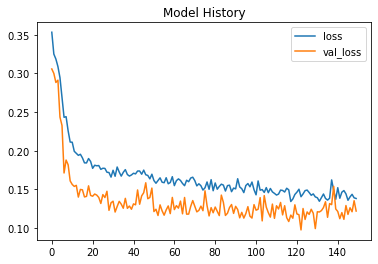

In [ ]:
plt.title('Model History')
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

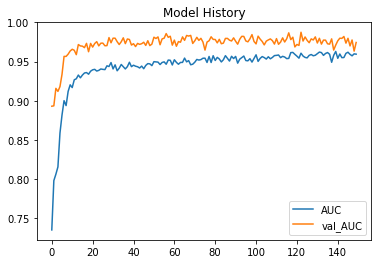

In [ ]:
plt.title('Model History')
plt.plot(r.history['auc'], label='AUC')
plt.plot(r.history['val_auc'], label='val_AUC')
plt.legend()

In [ ]:
results2 = model2.evaluate(datagen2.flow(X_test, y_test), verbose=0)
print(results2)
model2.save("model2150epNomods")
# model2 = tf.keras.models.load_model('model2150epNomods')

[0.1158628116615794, 76.0, 7.0, 599.0, 18.0, 0.96428573, 0.91566265, 0.80851066, 0.97589695, 0.9343542]
INFO:tensorflow:Assets written to: model2150epNomods/assets


### histogram equalised fitting

In [ ]:
model3 = createModel(bias)
model3.compile(loss='binary_crossentropy', run_eagerly=True,
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics=METRICS)
r3 = model3.fit(datagen3.flow(X_train2, y_train2, batch_size=128),
         validation_data=datagen3.flow(X_val2, y_val2,
         batch_size=8), epochs=150)

Train for 45 steps, validate for 79 steps
Epoch 1/150
45/45 [==============================] - 37s 832ms/step - loss: 0.3526 - tp: 111.0000 - fp: 50.0000 - tn: 4834.0000 - fn: 675.0000 - accuracy: 0.8721 - precision: 0.6894 - recall: 0.1412 - auc: 0.7434 - prc: 0.3641 - val_loss: 0.2929 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 537.0000 - val_fn: 93.0000 - val_accuracy: 0.8524 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9071 - val_prc: 0.7178
Epoch 2/150
45/45 [==============================] - 36s 789ms/step - loss: 0.2786 - tp: 345.0000 - fp: 138.0000 - tn: 4746.0000 - fn: 441.0000 - accuracy: 0.8979 - precision: 0.7143 - recall: 0.4389 - auc: 0.8496 - prc: 0.5847 - val_loss: 0.2319 - val_tp: 66.0000 - val_fp: 22.0000 - val_tn: 515.0000 - val_fn: 27.0000 - val_accuracy: 0.9222 - val_precision: 0.7500 - val_recall: 0.7097 - val_auc: 0.9261 - val_prc: 0.7844
Epoch 3/150
45/45 [==============================] - 39s 874ms/step - loss: 0.2603 - tp: 379.0000

2021-12-10 13:33:59.685925: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 35 of 45
2021-12-10 13:34:01.092022: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


45/45 [==============================] - 50s 1s/step - loss: 0.1688 - tp: 507.0000 - fp: 73.0000 - tn: 4811.0000 - fn: 279.0000 - accuracy: 0.9379 - precision: 0.8741 - recall: 0.6450 - auc: 0.9473 - prc: 0.8282 - val_loss: 0.1524 - val_tp: 64.0000 - val_fp: 6.0000 - val_tn: 531.0000 - val_fn: 29.0000 - val_accuracy: 0.9444 - val_precision: 0.9143 - val_recall: 0.6882 - val_auc: 0.9602 - val_prc: 0.8897
Epoch 103/150


2021-12-10 13:34:49.081658: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 37 of 45
2021-12-10 13:34:49.819360: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


45/45 [==============================] - 54s 1s/step - loss: 0.1714 - tp: 509.0000 - fp: 70.0000 - tn: 4814.0000 - fn: 277.0000 - accuracy: 0.9388 - precision: 0.8791 - recall: 0.6476 - auc: 0.9431 - prc: 0.8194 - val_loss: 0.1366 - val_tp: 72.0000 - val_fp: 12.0000 - val_tn: 525.0000 - val_fn: 21.0000 - val_accuracy: 0.9476 - val_precision: 0.8571 - val_recall: 0.7742 - val_auc: 0.9719 - val_prc: 0.9040
Epoch 104/150


2021-12-10 13:35:42.960550: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 32 of 45
2021-12-10 13:35:47.103523: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


45/45 [==============================] - 52s 1s/step - loss: 0.1733 - tp: 502.0000 - fp: 88.0000 - tn: 4796.0000 - fn: 284.0000 - accuracy: 0.9344 - precision: 0.8508 - recall: 0.6387 - auc: 0.9427 - prc: 0.8151 - val_loss: 0.1564 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 534.0000 - val_fn: 37.0000 - val_accuracy: 0.9365 - val_precision: 0.9492 - val_recall: 0.6022 - val_auc: 0.9684 - val_prc: 0.9028
Epoch 105/150


2021-12-10 13:36:34.648354: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 36 of 45
2021-12-10 13:36:35.950348: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


45/45 [==============================] - 50s 1s/step - loss: 0.1695 - tp: 498.0000 - fp: 67.0000 - tn: 4817.0000 - fn: 288.0000 - accuracy: 0.9374 - precision: 0.8814 - recall: 0.6336 - auc: 0.9438 - prc: 0.8244 - val_loss: 0.1565 - val_tp: 69.0000 - val_fp: 14.0000 - val_tn: 523.0000 - val_fn: 24.0000 - val_accuracy: 0.9397 - val_precision: 0.8313 - val_recall: 0.7419 - val_auc: 0.9693 - val_prc: 0.8764
Epoch 106/150
45/45 [==============================] - 40s 881ms/step - loss: 0.1664 - tp: 510.0000 - fp: 63.0000 - tn: 4821.0000 - fn: 276.0000 - accuracy: 0.9402 - precision: 0.8901 - recall: 0.6489 - auc: 0.9443 - prc: 0.8257 - val_loss: 0.1318 - val_tp: 74.0000 - val_fp: 8.0000 - val_tn: 529.0000 - val_fn: 19.0000 - val_accuracy: 0.9571 - val_precision: 0.9024 - val_recall: 0.7957 - val_auc: 0.9750 - val_prc: 0.9091
Epoch 107/150
45/45 [==============================] - 43s 965ms/step - loss: 0.1752 - tp: 479.0000 - fp: 64.0000 - tn: 4820.0000 - fn: 307.0000 - accuracy: 0.9346 - pr

2021-12-10 13:47:23.253612: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 39 of 45
2021-12-10 13:47:25.486378: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


45/45 [==============================] - 55s 1s/step - loss: 0.1741 - tp: 486.0000 - fp: 67.0000 - tn: 4817.0000 - fn: 300.0000 - accuracy: 0.9353 - precision: 0.8788 - recall: 0.6183 - auc: 0.9392 - prc: 0.8117 - val_loss: 0.1369 - val_tp: 70.0000 - val_fp: 6.0000 - val_tn: 531.0000 - val_fn: 23.0000 - val_accuracy: 0.9540 - val_precision: 0.9211 - val_recall: 0.7527 - val_auc: 0.9722 - val_prc: 0.9058
Epoch 121/150


2021-12-10 13:48:18.942234: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 30 of 45
2021-12-10 13:48:22.099319: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


45/45 [==============================] - 52s 1s/step - loss: 0.1636 - tp: 514.0000 - fp: 61.0000 - tn: 4823.0000 - fn: 272.0000 - accuracy: 0.9413 - precision: 0.8939 - recall: 0.6539 - auc: 0.9454 - prc: 0.8309 - val_loss: 0.1368 - val_tp: 66.0000 - val_fp: 7.0000 - val_tn: 530.0000 - val_fn: 27.0000 - val_accuracy: 0.9460 - val_precision: 0.9041 - val_recall: 0.7097 - val_auc: 0.9742 - val_prc: 0.9062
Epoch 122/150
45/45 [==============================] - 42s 926ms/step - loss: 0.1739 - tp: 497.0000 - fp: 69.0000 - tn: 4815.0000 - fn: 289.0000 - accuracy: 0.9369 - precision: 0.8781 - recall: 0.6323 - auc: 0.9413 - prc: 0.8147 - val_loss: 0.1325 - val_tp: 66.0000 - val_fp: 8.0000 - val_tn: 529.0000 - val_fn: 27.0000 - val_accuracy: 0.9444 - val_precision: 0.8919 - val_recall: 0.7097 - val_auc: 0.9780 - val_prc: 0.9093
Epoch 123/150
45/45 [==============================] - 40s 890ms/step - loss: 0.1657 - tp: 515.0000 - fp: 69.0000 - tn: 4815.0000 - fn: 271.0000 - accuracy: 0.9400 - pre

2021-12-10 13:53:22.004571: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 33 of 45
2021-12-10 13:53:24.645819: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


45/45 [==============================] - 57s 1s/step - loss: 0.1616 - tp: 510.0000 - fp: 64.0000 - tn: 4820.0000 - fn: 276.0000 - accuracy: 0.9400 - precision: 0.8885 - recall: 0.6489 - auc: 0.9495 - prc: 0.8333 - val_loss: 0.1422 - val_tp: 72.0000 - val_fp: 5.0000 - val_tn: 532.0000 - val_fn: 21.0000 - val_accuracy: 0.9587 - val_precision: 0.9351 - val_recall: 0.7742 - val_auc: 0.9699 - val_prc: 0.9093
Epoch 129/150
45/45 [==============================] - 44s 976ms/step - loss: 0.1643 - tp: 507.0000 - fp: 72.0000 - tn: 4812.0000 - fn: 279.0000 - accuracy: 0.9381 - precision: 0.8756 - recall: 0.6450 - auc: 0.9496 - prc: 0.8303 - val_loss: 0.1342 - val_tp: 68.0000 - val_fp: 5.0000 - val_tn: 532.0000 - val_fn: 25.0000 - val_accuracy: 0.9524 - val_precision: 0.9315 - val_recall: 0.7312 - val_auc: 0.9748 - val_prc: 0.9135
Epoch 130/150
45/45 [==============================] - 46s 1s/step - loss: 0.1586 - tp: 521.0000 - fp: 70.0000 - tn: 4814.0000 - fn: 265.0000 - accuracy: 0.9409 - precis

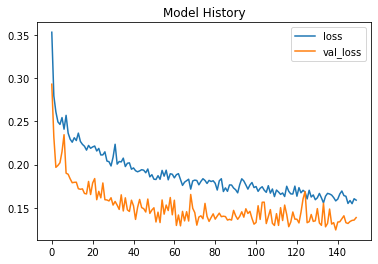

In [ ]:
plt.title('Model History')
plt.plot(r3.history['loss'], label='loss')
plt.plot(r3.history['val_loss'], label='val_loss')
plt.legend()

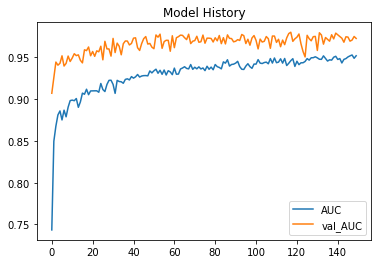

In [ ]:
plt.title('Model History')
plt.plot(r3.history['auc'], label='AUC')
plt.plot(r3.history['val_auc'], label='val_AUC')
plt.legend()

In [ ]:
results3 = model3.evaluate(datagen3.flow(X_test2, y_test2), verbose=0)
print(results3)
model3.save("model3150ephist")
# model2 = tf.keras.models.load_model('model2150epNomods')

[0.1488770902664824, 74.0, 13.0, 593.0, 20.0, 0.95285714, 0.85057473, 0.78723407, 0.9556912, 0.88129485]


2021-12-10 14:12:30.048347: W tensorflow/python/util/util.cc:299] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model3150ephist/assets


In [ ]:
results4 =transfer_model.evaluate(datagen2.flow(X_test, y_test), verbose=0)
print(results4)
transfer_model.save("transfer_model1150epnohist")

In [ ]:
transfer_model2 = createVgg16FT((32,32,3),biasMedian)
transfer_model2.compile(loss='binary_crossentropy', run_eagerly=True,
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics=METRICS)
r4 = transfer_model2.fit(datagen4.flow(X_train4, y_train4, batch_size=128),
         validation_data=datagen4.flow(X_val4, y_val4,
         batch_size=8), epochs=150)

Epoch 1/150
45/45 [==============================] - 13s 280ms/step - loss: 0.3073 - tp: 311.0000 - fp: 133.0000 - tn: 4751.0000 - fn: 475.0000 - accuracy: 0.8928 - precision: 0.7005 - recall: 0.3957 - auc: 0.8452 - prc: 0.5395 - val_loss: 0.2194 - val_tp: 71.0000 - val_fp: 26.0000 - val_tn: 511.0000 - val_fn: 22.0000 - val_accuracy: 0.9238 - val_precision: 0.7320 - val_recall: 0.7634 - val_auc: 0.9363 - val_prc: 0.7447
Epoch 2/150
45/45 [==============================] - 12s 273ms/step - loss: 0.2177 - tp: 473.0000 - fp: 147.0000 - tn: 4737.0000 - fn: 313.0000 - accuracy: 0.9189 - precision: 0.7629 - recall: 0.6018 - auc: 0.9243 - prc: 0.7296 - val_loss: 0.2029 - val_tp: 52.0000 - val_fp: 12.0000 - val_tn: 525.0000 - val_fn: 41.0000 - val_accuracy: 0.9159 - val_precision: 0.8125 - val_recall: 0.5591 - val_auc: 0.9407 - val_prc: 0.7664
Epoch 3/150
45/45 [==============================] - 12s 273ms/step - loss: 0.1863 - tp: 504.0000 - fp: 123.0000 - tn: 4761.0000 - fn: 282.0000 - accura

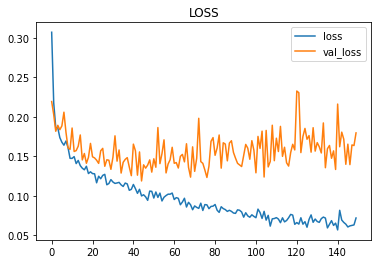

In [ ]:
plt.title('LOSS')
plt.plot(r4.history['loss'], label='loss')
plt.plot(r4.history['val_loss'], label='val_loss')
plt.legend()

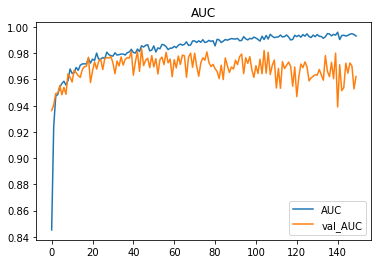

In [ ]:
plt.title('AUC')
plt.plot(r4.history['auc'], label='AUC')
plt.plot(r4.history['val_auc'], label='val_AUC')
plt.legend()

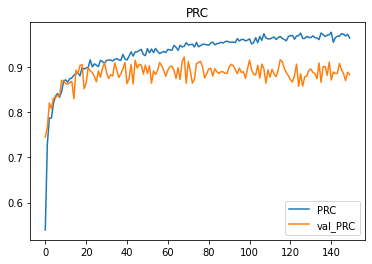

In [ ]:
plt.title('PRC')
plt.plot(r4.history['prc'], label='PRC')
plt.plot(r4.history['val_prc'], label='val_PRC')
plt.legend()

### On Unprocessed Images

In [ ]:
resnetTransferModel1 = createResnetTransferModel((50,50,3),bias)
resnetTransferModel1.compile(loss='binary_crossentropy', run_eagerly=True,
                optimizer=tf.keras.optimizers.SGD(
    learning_rate=1e-3, momentum=0.9, nesterov=False, name='SGD'),
                metrics=METRICS)

In [ ]:
resnetTransferModel1.summary()

In [ ]:
rs1 = resnetTransferModel1.fit(datagen2.flow(X_train, y_train, batch_size=128),
         validation_data=datagen2.flow(X_val, y_val,
         batch_size=8), epochs=200)

Epoch 1/200
45/45 [==============================] - 18s 406ms/step - loss: 0.3203 - tp: 142.0000 - fp: 82.0000 - tn: 4802.0000 - fn: 644.0000 - accuracy: 0.8720 - precision: 0.6339 - recall: 0.1807 - auc: 0.8134 - prc: 0.4466 - val_loss: 0.2906 - val_tp: 32.0000 - val_fp: 9.0000 - val_tn: 528.0000 - val_fn: 61.0000 - val_accuracy: 0.8889 - val_precision: 0.7805 - val_recall: 0.3441 - val_auc: 0.8667 - val_prc: 0.6226
Epoch 2/200
45/45 [==============================] - 18s 404ms/step - loss: 0.2796 - tp: 265.0000 - fp: 111.0000 - tn: 4773.0000 - fn: 521.0000 - accuracy: 0.8885 - precision: 0.7048 - recall: 0.3372 - auc: 0.8653 - prc: 0.5810 - val_loss: 0.2874 - val_tp: 19.0000 - val_fp: 4.0000 - val_tn: 533.0000 - val_fn: 74.0000 - val_accuracy: 0.8762 - val_precision: 0.8261 - val_recall: 0.2043 - val_auc: 0.8880 - val_prc: 0.6462
Epoch 3/200
45/45 [==============================] - 18s 405ms/step - loss: 0.2796 - tp: 271.0000 - fp: 112.0000 - tn: 4772.0000 - fn: 515.0000 - accuracy:

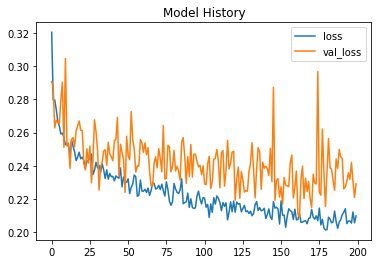

In [ ]:
plt.title('Model History')
plt.plot(rs1.history['loss'], label='loss')
plt.plot(rs1.history['val_loss'], label='val_loss')
plt.legend()

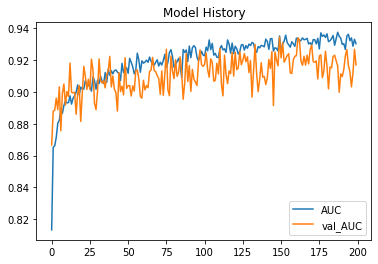

In [ ]:
plt.title('Model History')
plt.plot(rs1.history['auc'], label='AUC')
plt.plot(rs1.history['val_auc'], label='val_AUC')
plt.legend()

In [ ]:
# resultsRs1 =resnetTransferModel.evaluate(datagen2.flow(X_test, y_test), verbose=0)
# print(resultsRs1)
# resnetTransferModel.save("Resnet1")

### On Median Images

In [ ]:
resnetTransferModel2 = createResnetTransferModel((32,32,3),biasMedian)
resnetTransferModel2.compile(loss='binary_crossentropy', run_eagerly=True,
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                metrics=METRICS)

In [ ]:
rs2 = resnetTransferModel2.fit(datagen4.flow(X_train4, y_train4, batch_size=128),
         validation_data=datagen4.flow(X_val4, y_val4,
         batch_size=8), epochs=60)

Epoch 1/60
45/45 [==============================] - 19s 419ms/step - loss: 0.4451 - tp: 83.0000 - fp: 218.0000 - tn: 4666.0000 - fn: 703.0000 - accuracy: 0.8376 - precision: 0.2757 - recall: 0.1056 - auc: 0.6600 - prc: 0.2174 - val_loss: 0.3509 - val_tp: 1.0000 - val_fp: 2.0000 - val_tn: 535.0000 - val_fn: 92.0000 - val_accuracy: 0.8508 - val_precision: 0.3333 - val_recall: 0.0108 - val_auc: 0.8191 - val_prc: 0.4485
Epoch 2/60
45/45 [==============================] - 18s 398ms/step - loss: 0.3554 - tp: 31.0000 - fp: 40.0000 - tn: 4844.0000 - fn: 755.0000 - accuracy: 0.8598 - precision: 0.4366 - recall: 0.0394 - auc: 0.7492 - prc: 0.3032 - val_loss: 0.3366 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 537.0000 - val_fn: 93.0000 - val_accuracy: 0.8524 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8350 - val_prc: 0.4901
Epoch 3/60
45/45 [==============================] - 19s 417ms/step - loss: 0.3388 - tp: 67.0000 - fp: 51.0000 - tn: 4833.0000 - fn: 719.0000 - ac

In [ ]:
for layer in resnetTransferModel2.layers:
  if layer.name in ['res5c_branch2b', 'res5c_branch2c', 'activation_97']:
    layer.trainable = True
  else:
     layer.trainable = False

resnetTransferModel2.compile(loss='binary_crossentropy', run_eagerly=True,
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
                metrics=METRICS)
rs2 = resnetTransferModel2.fit(datagen4.flow(X_train4, y_train4, batch_size=128),
         validation_data=datagen4.flow(X_val4, y_val4,
         batch_size=8), epochs=120)

Epoch 1/120
45/45 [==============================] - 19s 415ms/step - loss: 0.2825 - tp: 328.0000 - fp: 173.0000 - tn: 5248.0000 - fn: 551.0000 - accuracy: 0.8851 - precision: 0.6547 - recall: 0.3732 - auc: 0.8692 - prc: 0.5656 - val_loss: 0.2915 - val_tp: 35.0000 - val_fp: 13.0000 - val_tn: 524.0000 - val_fn: 58.0000 - val_accuracy: 0.8873 - val_precision: 0.7292 - val_recall: 0.3763 - val_auc: 0.8762 - val_prc: 0.6001
Epoch 2/120
45/45 [==============================] - 18s 411ms/step - loss: 0.2907 - tp: 274.0000 - fp: 145.0000 - tn: 4739.0000 - fn: 512.0000 - accuracy: 0.8841 - precision: 0.6539 - recall: 0.3486 - auc: 0.8594 - prc: 0.5412 - val_loss: 0.3042 - val_tp: 38.0000 - val_fp: 18.0000 - val_tn: 519.0000 - val_fn: 55.0000 - val_accuracy: 0.8841 - val_precision: 0.6786 - val_recall: 0.4086 - val_auc: 0.8589 - val_prc: 0.5742
Epoch 3/120
45/45 [==============================] - 18s 400ms/step - loss: 0.2918 - tp: 281.0000 - fp: 155.0000 - tn: 4729.0000 - fn: 505.0000 - accura

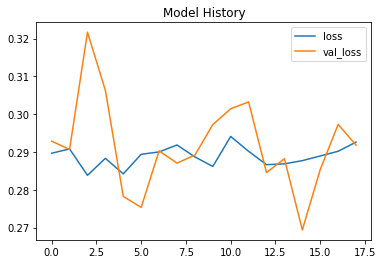

In [ ]:
plt.title('Model History')
plt.plot(rs2.history['loss'], label='loss')
plt.plot(rs2.history['val_loss'], label='val_loss')
plt.legend()

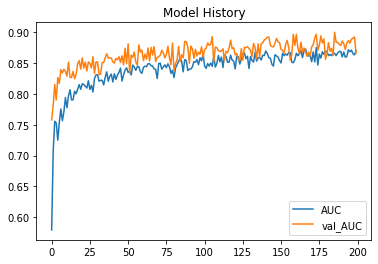

In [ ]:
plt.title('Model History')
plt.plot(rs2.history['auc'], label='AUC')
plt.plot(rs2.history['val_auc'], label='val_AUC')
plt.legend()

In [ ]:
resultsRs2 =resnetTransferModel2.evaluate(datagen4.flow(X_test4, y_test4), verbose=0)
print(resultsRs2)
# resnetTransferModel.save("Resnet1")

[0.2939039468765259, 31.0, 12.0, 594.0, 63.0, 0.8928571343421936, 0.7209302186965942, 0.3297872245311737, 0.834263801574707, 0.5119807720184326]


## Simple Small CNN

### on median data

In [ ]:
s_model = smallModel((32,32,3),biasMedian)
s_model.compile(loss='binary_crossentropy', run_eagerly=True,
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),metrics=METRICS)


In [ ]:
rS = s_model.fit(datagen4.flow(X_train4, y_train4, batch_size=128),
         validation_data=datagen4.flow(X_val4, y_val4,
         batch_size=8), epochs=200,callbacks=[callback])

Epoch 1/200
45/45 [==============================] - 10s 221ms/step - loss: 0.0693 - tp: 695.0000 - fp: 53.0000 - tn: 4831.0000 - fn: 91.0000 - accuracy: 0.9746 - precision: 0.9291 - recall: 0.8842 - auc: 0.9915 - prc: 0.9667 - val_loss: 0.1171 - val_tp: 75.0000 - val_fp: 11.0000 - val_tn: 526.0000 - val_fn: 18.0000 - val_accuracy: 0.9540 - val_precision: 0.8721 - val_recall: 0.8065 - val_auc: 0.9847 - val_prc: 0.9257
Epoch 2/200
45/45 [==============================] - 10s 220ms/step - loss: 0.0780 - tp: 684.0000 - fp: 59.0000 - tn: 4825.0000 - fn: 102.0000 - accuracy: 0.9716 - precision: 0.9206 - recall: 0.8702 - auc: 0.9885 - prc: 0.9613 - val_loss: 0.1399 - val_tp: 74.0000 - val_fp: 12.0000 - val_tn: 525.0000 - val_fn: 19.0000 - val_accuracy: 0.9508 - val_precision: 0.8605 - val_recall: 0.7957 - val_auc: 0.9724 - val_prc: 0.9076
Epoch 3/200
45/45 [==============================] - 10s 223ms/step - loss: 0.0673 - tp: 694.0000 - fp: 55.0000 - tn: 4829.0000 - fn: 92.0000 - accuracy: 0

In [ ]:
resultBM2 = s_model.evaluate(datagen4.flow(X_test4, y_test4))
print(resultBM2)
s_model.save("BM2")

22/22 [==============================] - 1s 63ms/step - loss: 0.1282 - tp: 81.0000 - fp: 10.0000 - tn: 596.0000 - fn: 13.0000 - accuracy: 0.9671 - precision: 0.8901 - recall: 0.8617 - auc: 0.9751 - prc: 0.9270
[0.12822668254375458, 81.0, 10.0, 596.0, 13.0, 0.9671428799629211, 0.8901098966598511, 0.8617021441459656, 0.9750632047653198, 0.9269683361053467]
INFO:tensorflow:Assets written to: BM2/assets


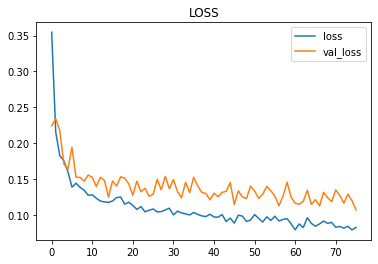

In [ ]:
plt.title('LOSS')
plt.plot(rS.history['loss'], label='loss')
plt.plot(rS.history['val_loss'], label='val_loss')
plt.legend()

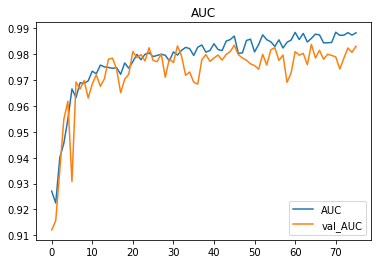

In [ ]:
plt.title('AUC')
plt.plot(rS.history['auc'], label='AUC')
plt.plot(rS.history['val_auc'], label='val_AUC')
plt.legend()

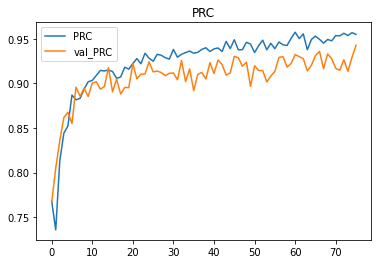

In [ ]:
plt.title('PRC')
plt.plot(rS.history['prc'], label='PRC')
plt.plot(rS.history['val_prc'], label='val_PRC')
plt.legend()

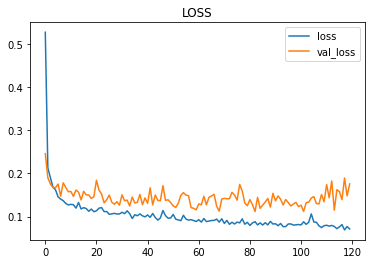

In [ ]:
plt.title('LOSS')
plt.plot(rS.history['loss'], label='loss')
plt.plot(rS.history['val_loss'], label='val_loss')
plt.legend()

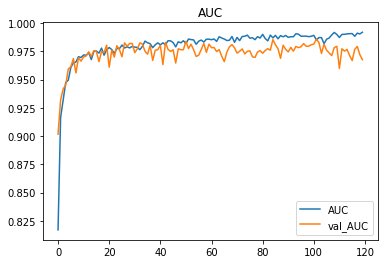

In [ ]:
plt.title('AUC')
plt.plot(rS.history['auc'], label='AUC')
plt.plot(rS.history['val_auc'], label='val_AUC')
plt.legend()

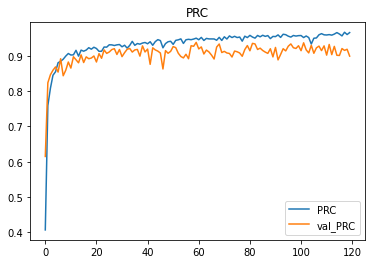

In [ ]:
plt.title('PRC')
plt.plot(rS.history['prc'], label='PRC')
plt.plot(rS.history['val_prc'], label='val_PRC')
plt.legend()

In [ ]:
s_model2 = smallModel((50,50,3),bias)
s_model2.compile(loss='binary_crossentropy', run_eagerly=True,
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),metrics=METRICS)
rS2 = s_model2.fit(datagen6.flow(X_train6, y_train6, batch_size=128),
         validation_data=datagen6.flow(X_val6, y_val6,
         batch_size=8), epochs=200)

Epoch 1/200
45/45 [==============================] - 13s 298ms/step - loss: 0.5523 - tp: 2.0000 - fp: 31.0000 - tn: 5053.0000 - fn: 816.0000 - accuracy: 0.8565 - precision: 0.0606 - recall: 0.0024 - auc: 0.5720 - prc: 0.1643 - val_loss: 0.4165 - val_tp: 0.0000e+00 - val_fp: 2.0000 - val_tn: 535.0000 - val_fn: 93.0000 - val_accuracy: 0.8492 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5207 - val_prc: 0.1914
Epoch 2/200
45/45 [==============================] - 13s 299ms/step - loss: 0.3857 - tp: 6.0000 - fp: 8.0000 - tn: 4876.0000 - fn: 780.0000 - accuracy: 0.8610 - precision: 0.4286 - recall: 0.0076 - auc: 0.6424 - prc: 0.2133 - val_loss: 0.3765 - val_tp: 7.0000 - val_fp: 1.0000 - val_tn: 536.0000 - val_fn: 86.0000 - val_accuracy: 0.8619 - val_precision: 0.8750 - val_recall: 0.0753 - val_auc: 0.7065 - val_prc: 0.3485
Epoch 3/200
45/45 [==============================] - 13s 299ms/step - loss: 0.3731 - tp: 34.0000 - fp: 22.0000 - tn: 4862.0000 - fn: 752.0000 - accurac

### 3rd on adapt equalised data

In [ ]:
s_model3 = smallModel((50,50,3),bias)
s_model3.compile(loss='binary_crossentropy', run_eagerly=True,
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),metrics=METRICS)
rS3 = s_model3.fit(datagen7.flow(X_train7, y_train7, batch_size=128),
         validation_data=datagen7.flow(X_val7, y_val7,
         batch_size=8), epochs=200,callbacks=[callback])


Epoch 1/200
45/45 [==============================] - 16s 349ms/step - loss: 0.3934 - tp: 299.0000 - fp: 313.0000 - tn: 9005.0000 - fn: 1211.0000 - accuracy: 0.8593 - precision: 0.4886 - recall: 0.1980 - auc: 0.7661 - prc: 0.3929 - val_loss: 0.2865 - val_tp: 16.0000 - val_fp: 5.0000 - val_tn: 532.0000 - val_fn: 77.0000 - val_accuracy: 0.8698 - val_precision: 0.7619 - val_recall: 0.1720 - val_auc: 0.8907 - val_prc: 0.6135
Epoch 2/200
45/45 [==============================] - 16s 350ms/step - loss: 0.2681 - tp: 267.0000 - fp: 188.0000 - tn: 4696.0000 - fn: 519.0000 - accuracy: 0.8753 - precision: 0.5868 - recall: 0.3397 - auc: 0.8869 - prc: 0.5057 - val_loss: 0.2577 - val_tp: 53.0000 - val_fp: 23.0000 - val_tn: 514.0000 - val_fn: 40.0000 - val_accuracy: 0.9000 - val_precision: 0.6974 - val_recall: 0.5699 - val_auc: 0.9043 - val_prc: 0.6263
Epoch 3/200
45/45 [==============================] - 16s 346ms/step - loss: 0.2577 - tp: 305.0000 - fp: 207.0000 - tn: 4677.0000 - fn: 481.0000 - accura

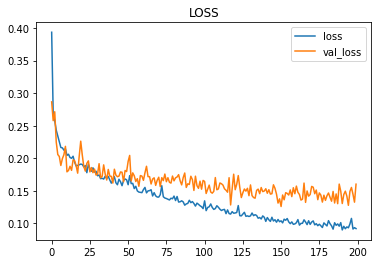

In [ ]:
plt.title('LOSS')
plt.plot(rS3.history['loss'], label='loss')
plt.plot(rS3.history['val_loss'], label='val_loss')
plt.legend()

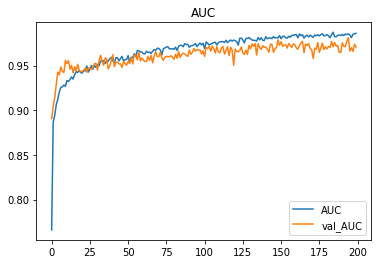

In [ ]:
plt.title('AUC')
plt.plot(rS3.history['auc'], label='AUC')
plt.plot(rS3.history['val_auc'], label='val_AUC')
plt.legend()

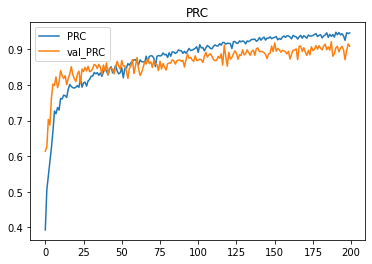

In [ ]:
plt.title('PRC')
plt.plot(rS3.history['prc'], label='PRC')
plt.plot(rS3.history['val_prc'], label='val_PRC')
plt.legend()

In [ ]:
resultBM1 = s_model3.evaluate(datagen7.flow(X_test7, y_test7))
print(resultBM1)
s_model3.save("BM1")

178/178 [==============================] - 16s 92ms/step - loss: 0.0972 - tp: 594.0000 - fp: 23.0000 - tn: 4861.0000 - fn: 192.0000 - accuracy: 0.9621 - precision: 0.9627 - recall: 0.7557 - auc: 0.9875 - prc: 0.9540
[0.097248874604702, 594.0, 23.0, 4861.0, 192.0, 0.9620811343193054, 0.9627228379249573, 0.7557252049446106, 0.9875485301017761, 0.9540199041366577]
INFO:tensorflow:Assets written to: BM1/assets


In [ ]:
xctl = TLxcModel((71,71,3),biasMedian2)
xctl.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)
xctl.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 71, 71, 3)]       0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_12 (Dense)            (None, 1)                 2049      
                                                                 
Total params: 20,863,529
Trainable params: 2,049
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
xcresult = xctl.fit(datagen5.flow(X_train5, y_train5, batch_size=128),
         validation_data=datagen5.flow(X_val5, y_val5,
         batch_size=8), epochs=50)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


45/45 [==============================] - 17s 270ms/step - loss: 0.3317 - tp: 367.0000 - fp: 120.0000 - tn: 6091.0000 - fn: 628.0000 - accuracy: 0.8945 - precision: 0.7463 - recall: 0.3579 - auc: 0.8490 - prc: 0.6023 - val_loss: 0.2858 - val_tp: 33.0000 - val_fp: 12.0000 - val_tn: 525.0000 - val_fn: 60.0000 - val_accuracy: 0.8857 - val_precision: 0.7333 - val_recall: 0.3548 - val_auc: 0.8753 - val_prc: 0.6234
Epoch 2/50
45/45 [==============================] - 10s 221ms/step - loss: 0.2858 - tp: 275.0000 - fp: 96.0000 - tn: 4788.0000 - fn: 511.0000 - accuracy: 0.8929 - precision: 0.7412 - recall: 0.3499 - auc: 0.8602 - prc: 0.5728 - val_loss: 0.2880 - val_tp: 38.0000 - val_fp: 18.0000 - val_tn: 519.0000 - val_fn: 55.0000 - val_accuracy: 0.8841 - val_precision: 0.6786 - val_recall: 0.4086 - val_auc: 0.8653 - val_prc: 0.6325
Epoch 3/50
45/45 [==============================] - 10s 220ms/step - loss: 0.2712 - tp: 289.0000 - fp: 95.0000 - tn: 4789.0000 - fn: 497.0000 - accuracy: 0.8956 - pre

In [ ]:
xctl.trainable = True
xctl.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 71, 71, 3)]       0         
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_12 (Dense)            (None, 1)                 2049      
                                                                 
Total params: 20,863,529
Trainable params: 20,809,001
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
xctl.compile(optimizer=tf.keras.optimizers.Adam(1e-7),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=METRICS)

In [ ]:
xcresult_=xctl.fit(datagen5.flow(X_train5, y_train5, batch_size=128),
         validation_data=datagen5.flow(X_val5, y_val5,
         batch_size=8), epochs=300,callbacks=[callback])

Epoch 1/300


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


45/45 [==============================] - 20s 293ms/step - loss: 0.2161 - tp: 510.0000 - fp: 155.0000 - tn: 5266.0000 - fn: 369.0000 - accuracy: 0.9168 - precision: 0.7669 - recall: 0.5802 - auc: 0.9200 - prc: 0.7506 - val_loss: 0.2340 - val_tp: 53.0000 - val_fp: 17.0000 - val_tn: 520.0000 - val_fn: 40.0000 - val_accuracy: 0.9095 - val_precision: 0.7571 - val_recall: 0.5699 - val_auc: 0.9178 - val_prc: 0.7319
Epoch 2/300
45/45 [==============================] - 11s 250ms/step - loss: 0.2177 - tp: 440.0000 - fp: 136.0000 - tn: 4748.0000 - fn: 346.0000 - accuracy: 0.9150 - precision: 0.7639 - recall: 0.5598 - auc: 0.9210 - prc: 0.7394 - val_loss: 0.2322 - val_tp: 56.0000 - val_fp: 17.0000 - val_tn: 520.0000 - val_fn: 37.0000 - val_accuracy: 0.9143 - val_precision: 0.7671 - val_recall: 0.6022 - val_auc: 0.9119 - val_prc: 0.7433
Epoch 3/300
45/45 [==============================] - 11s 245ms/step - loss: 0.2138 - tp: 444.0000 - fp: 126.0000 - tn: 4758.0000 - fn: 342.0000 - accuracy: 0.9175 -

In [ ]:
plt.title('PRC')
plt.plot(xcresult_.history['prc'], label='PRC')
plt.plot(xcresult_.history['val_prc'], label='val_PRC')
plt.legend()

In [ ]:
plt.title('AUC')
plt.plot(xcresult_.history['auc'], label='AUC')
plt.plot(xcresult_.history['val_auc'], label='val_AUC')
plt.legend()

In [ ]:
plt.title('LOSS')
plt.plot(xcresult_.history['loss'], label='loss')
plt.plot(xcresult_.history['val_loss'], label='val_loss')
plt.legend()

In [ ]:
resultBM3 = xctl.evaluate(datagen5.flow(X_test5, y_test5))
print(resultBM1)
s_model3.save("BM1")

22/22 [==============================] - 1s 54ms/step - loss: 0.1954 - tp: 60.0000 - fp: 9.0000 - tn: 597.0000 - fn: 34.0000 - accuracy: 0.9386 - precision: 0.8696 - recall: 0.6383 - auc: 0.9256 - prc: 0.8034
[0.097248874604702, 594.0, 23.0, 4861.0, 192.0, 0.9620811343193054, 0.9627228379249573, 0.7557252049446106, 0.9875485301017761, 0.9540199041366577]
INFO:tensorflow:Assets written to: BM1/assets
